# Recommendation System Project


In [2]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import dask.dataframe as dd
import missingno as msno 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import joblib

import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares 

## LOAD DATASETS

In [ ]:
def load_data():
    """Load events, item properties, and category tree data."""
    events_path = 'events.csv'
    properties_path = 'item_properties_part1.1.csv'
    properties_path_2 = 'item_properties_part2.csv'
    category_tree_path = 'category_tree.csv'
    
    # Load events data
    events = pd.read_csv(
        events_path, 
        header=None, 
        names=['timestamp', 'visitor_id', 'event_type', 'item_id', 'transaction_id']
    )
    
    # Load both parts of item properties and concatenate them
    item_properties_part1 = pd.read_csv(
        properties_path, 
        header=None, 
        names=['timestamp', 'item_id', 'property', 'value']
    )
    item_properties_part2 = pd.read_csv(
        properties_path_2, 
        header=None, 
        names=['timestamp', 'item_id', 'property', 'value']
    )
    item_properties = pd.concat([item_properties_part1, item_properties_part2], ignore_index=True)
    
    # Load category tree data
    category_tree = pd.read_csv(
        category_tree_path, 
        header=None, 
        names=['child_category', 'parent_category']
    )
    
    # Convert timestamps to datetime (assumes Unix timestamps in milliseconds)
    events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms', errors='coerce')
    item_properties['timestamp'] = pd.to_datetime(item_properties['timestamp'], unit='ms', errors='coerce')
    
    # Sort the data by timestamp for merge_asof to work properly
    events.sort_values('timestamp', inplace=True)
    item_properties.sort_values('timestamp', inplace=True)
    
    return events, item_properties, category_tree

if __name__ == "__main__":
    events, item_properties, category_tree = load_data()
    print("Events data shape:", events.shape)
    print("Item properties data shape:", item_properties.shape)
    print("Category tree data shape:", category_tree.shape)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_24444\3500727436.py:9: DtypeWarning: Columns (0,1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_24444\3500727436.py:16: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  item_properties_part1 = pd.read_csv(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_24444\3500727436.py:21: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  item_properties_part2 = pd.read_csv(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_24444\3500727436.py:36: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  events['ti

Events data shape: (2756102, 5)
Item properties data shape: (20275904, 4)
Category tree data shape: (1670, 2)


#### VIEW 'EVENTS' DATASET

In [3]:
print("Events Data (first 5 rows):")
print(events.head(), "\n")

Events Data (first 5 rows):
                      timestamp visitor_id event_type item_id transaction_id
1462975 2015-05-03 03:00:04.384     693516  addtocart  297662            NaN
1464807 2015-05-03 03:00:11.289     829044       view   60987            NaN
1463001 2015-05-03 03:00:13.048     652699       view  252860            NaN
1465288 2015-05-03 03:00:24.154    1125936       view   33661            NaN
1462956 2015-05-03 03:00:26.228     693516       view  297662            NaN 



In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2756102 entries, 1462975 to 0
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       datetime64[ns]
 1   visitor_id      object        
 2   event_type      object        
 3   item_id         object        
 4   transaction_id  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 126.2+ MB


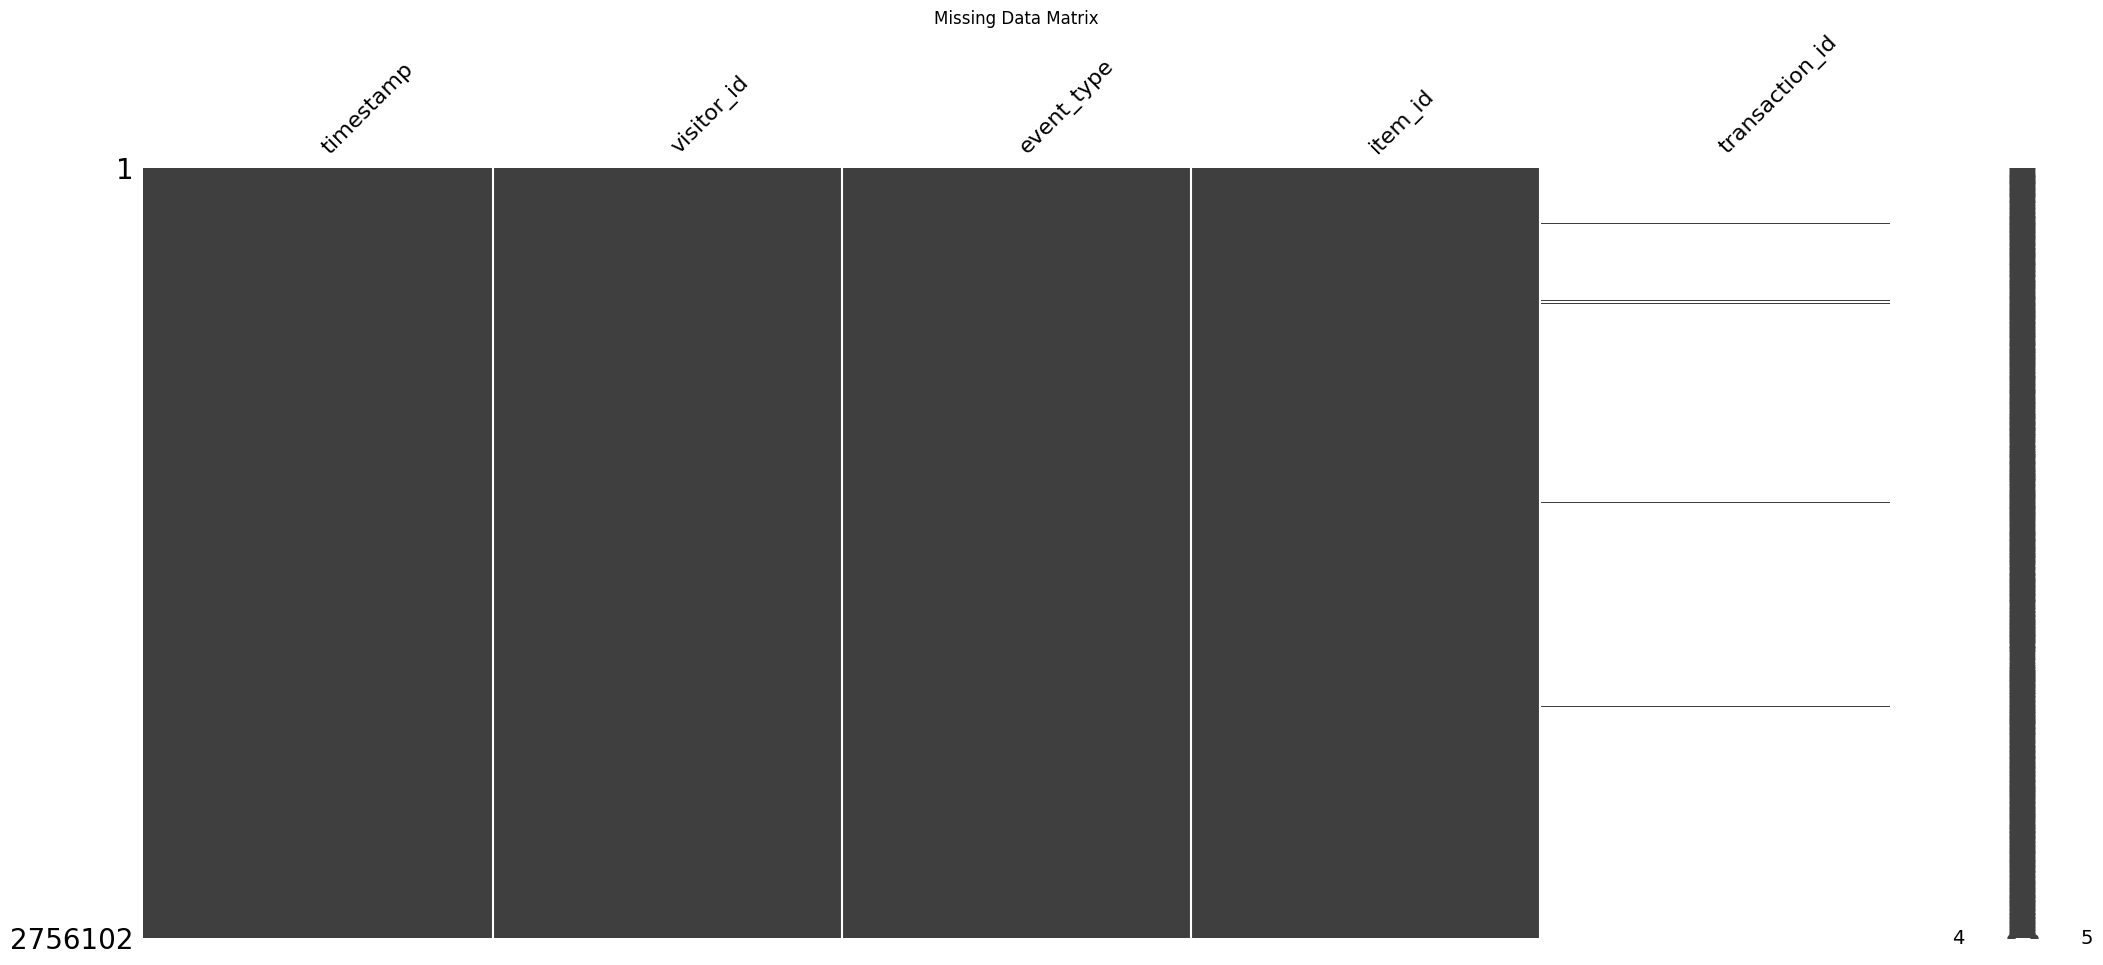

In [18]:
# Visualization using missingno (matrix)
msno.matrix(events)
plt.title("Missing Data Matrix")
plt.show()

#### VIEW 'ITEM-PROPERTIES' DATASET

In [5]:
print("Item Properties Data (first 5 rows):")
print(item_properties.head(), "\n")

Item Properties Data (first 5 rows):
                   timestamp item_id   property       value
5903680  2015-05-10 03:00:00  317951        790  n32880.000
5668946  2015-05-10 03:00:00  422842        480     1133979
11314221 2015-05-10 03:00:00  310185        776      103591
15170324 2015-05-10 03:00:00  110973        112      679677
15170325 2015-05-10 03:00:00  179597  available           0 



In [6]:
item_properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275904 entries, 5903680 to 11000000
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   item_id    object        
 2   property   object        
 3   value      object        
dtypes: datetime64[ns](1), object(3)
memory usage: 773.5+ MB


c:\Users\lenovo\Documents\Documents\personal\Azubi Africa\Talent Mobility Program\P2\TMP2-Recommendation-system-project\env\lib\site-packages\matplotlib\image.py:183: UserWarning: Data with more than 2**24 rows cannot be accurately displayed. Downsampling to less than 2**24 rows before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**24 rows'))


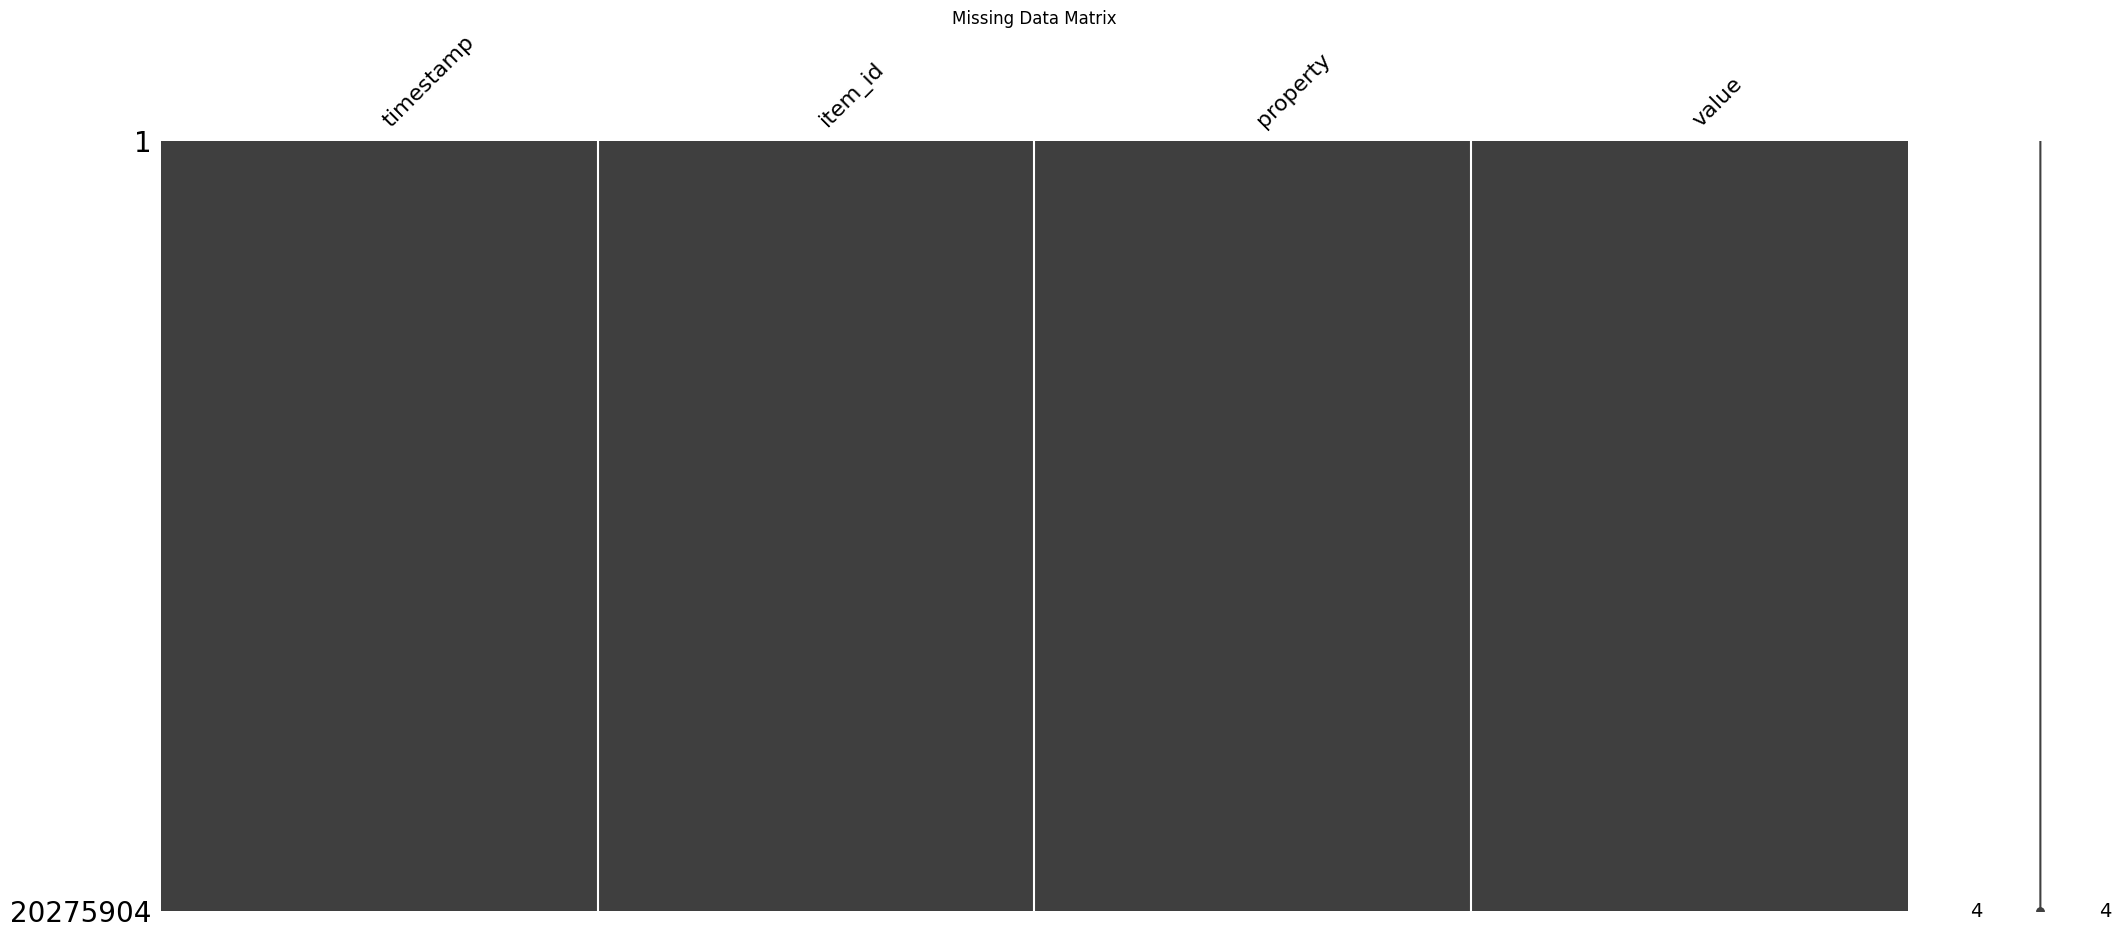

In [17]:
# Visualization using missingno (matrix)
msno.matrix(item_properties)
plt.title("Missing Data Matrix")
plt.show()

#### VIEW 'CATEGORY-TREE' DATASET

In [7]:
print("Category Tree Data (first 5 rows):")
print(category_tree.head(), "\n")

Category Tree Data (first 5 rows):
  child_category parent_category
0     categoryid        parentid
1           1016             213
2            809             169
3            570               9
4           1691             885 



In [8]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   child_category   1670 non-null   object
 1   parent_category  1645 non-null   object
dtypes: object(2)
memory usage: 26.2+ KB


## MERGE 'EVENTS' WITH 'ITEM-PROPERTIES' INTO ONE TABLE

In [11]:
# Check and handle missing timestamps in item_properties (right side)
print("Missing timestamps in item_properties before imputation:", item_properties['timestamp'].isnull().sum())
item_properties['timestamp'] = item_properties['timestamp'].fillna(method='ffill').fillna(method='bfill')
print("Missing timestamps in item_properties after imputation:", item_properties['timestamp'].isnull().sum())

# (Optional) If null values still exist and cannot be imputed meaningfully, consider dropping them:
if item_properties['timestamp'].isnull().any():
    item_properties = item_properties.dropna(subset=['timestamp'])
    
# Ensure both DataFrames are sorted by timestamp
events.sort_values('timestamp', inplace=True)
item_properties.sort_values('timestamp', inplace=True)

# Now perform the merge_asof using both timestamp and item_id
merged_df = pd.merge_asof(
    events,
    item_properties,
    left_on='timestamp',
    right_on='timestamp',
    by='item_id',
    direction='backward'
)

print("Merged DataFrame (first 5 rows):")
print(merged_df.head())

Missing timestamps in item_properties before imputation: 2


C:\Users\lenovo\AppData\Local\Temp\ipykernel_24444\1259800675.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_properties['timestamp'] = item_properties['timestamp'].fillna(method='ffill').fillna(method='bfill')


Missing timestamps in item_properties after imputation: 0
Merged DataFrame (first 5 rows):
                timestamp visitor_id event_type item_id transaction_id  \
0 2015-05-03 03:00:04.384     693516  addtocart  297662            NaN   
1 2015-05-03 03:00:11.289     829044       view   60987            NaN   
2 2015-05-03 03:00:13.048     652699       view  252860            NaN   
3 2015-05-03 03:00:24.154    1125936       view   33661            NaN   
4 2015-05-03 03:00:26.228     693516       view  297662            NaN   

  property value  
0      NaN   NaN  
1      NaN   NaN  
2      NaN   NaN  
3      NaN   NaN  
4      NaN   NaN  


In [12]:
# View missing data counts per column
print("Missing data counts per column:")
print(merged_df.isnull().sum())

Missing data counts per column:
timestamp               0
visitor_id              0
event_type              0
item_id                 0
transaction_id    2733644
property           480875
value              480875
dtype: int64


In [13]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756102 entries, 0 to 2756101
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       datetime64[ns]
 1   visitor_id      object        
 2   event_type      object        
 3   item_id         object        
 4   transaction_id  object        
 5   property        object        
 6   value           object        
dtypes: datetime64[ns](1), object(6)
memory usage: 147.2+ MB


#### EDA BEFORE DATA CLEANING

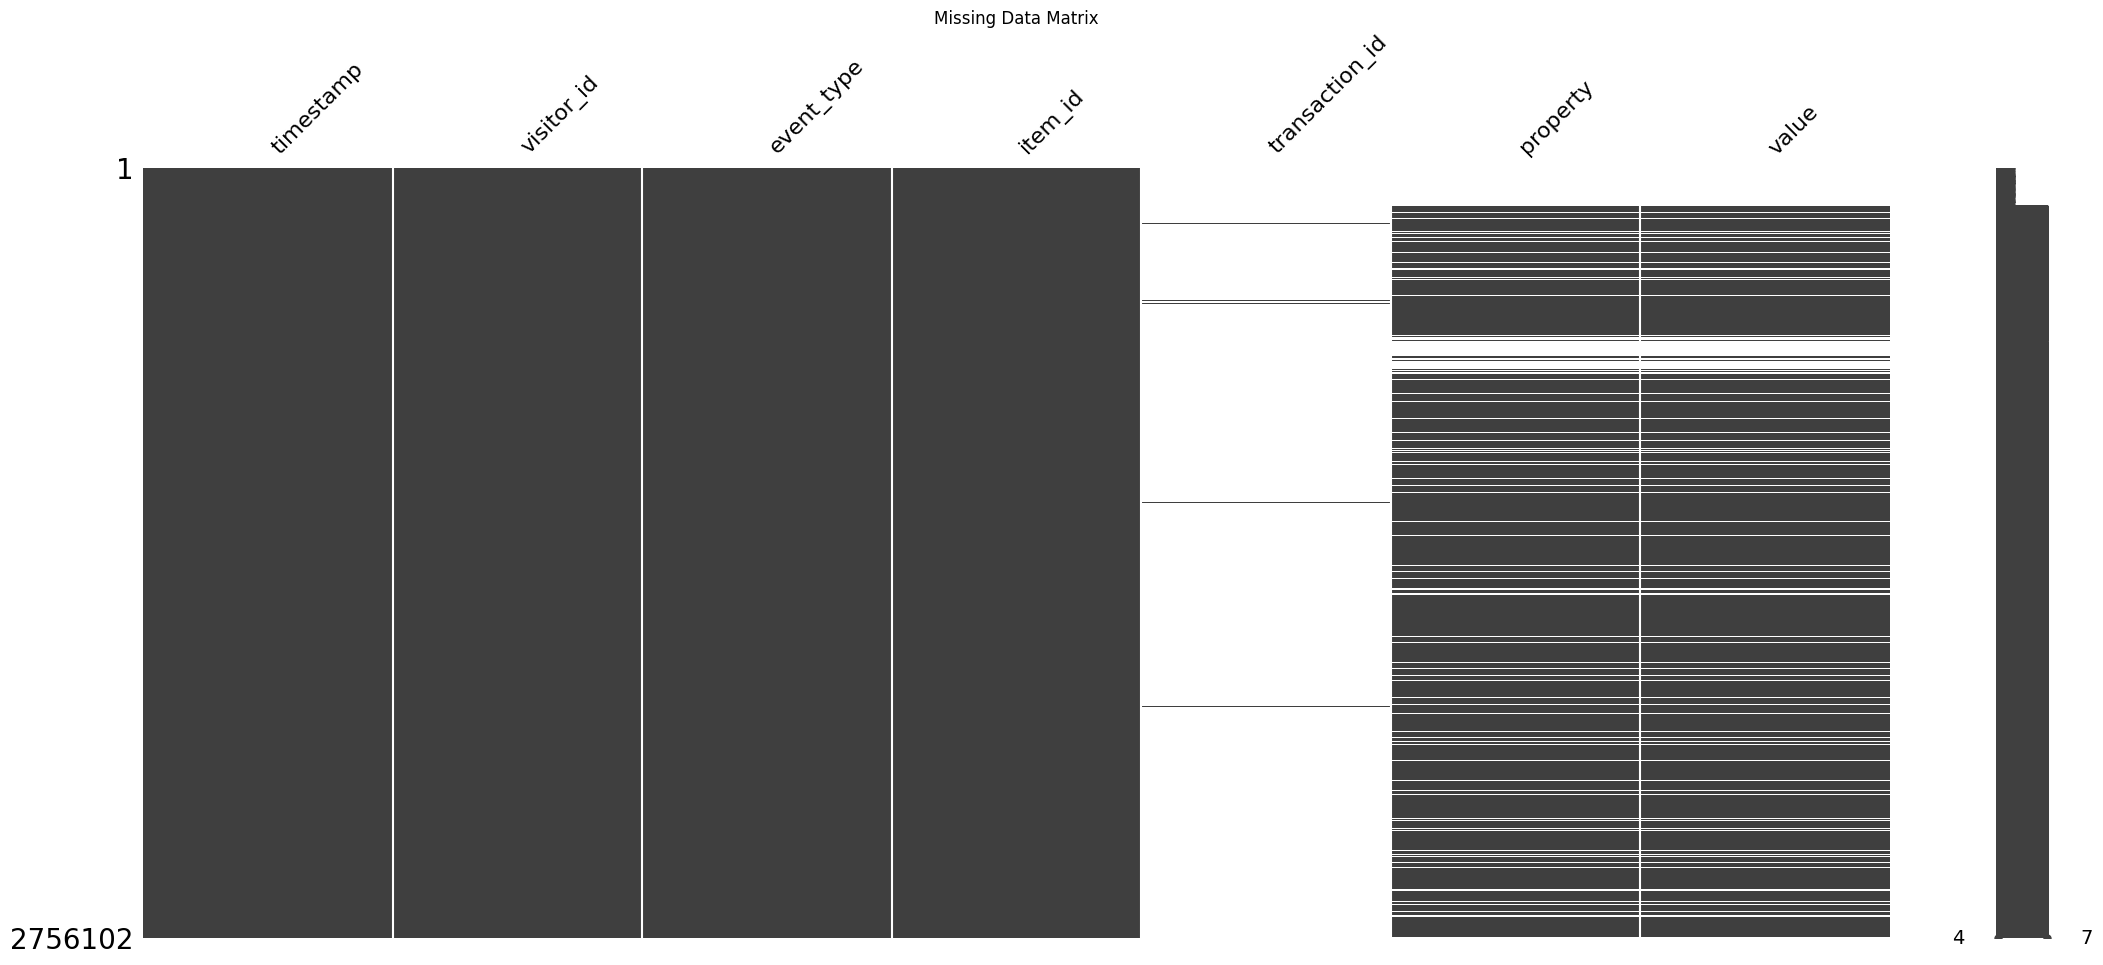

In [19]:
# Visualization using missingno (matrix)
msno.matrix(merged_df)
plt.title("Missing Data Matrix")
plt.show()

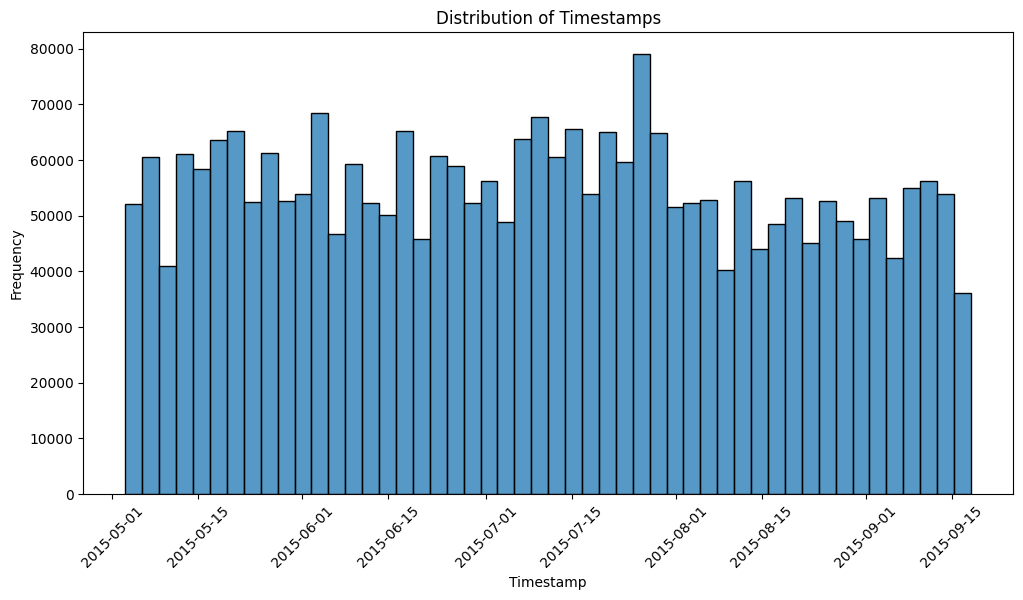

In [20]:
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['timestamp'], bins=50, kde=False)
plt.title("Distribution of Timestamps")
plt.xlabel("Timestamp")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()



Event Type Counts:
event_type
view           2664312
addtocart        69332
transaction      22457
event                1
Name: count, dtype: int64


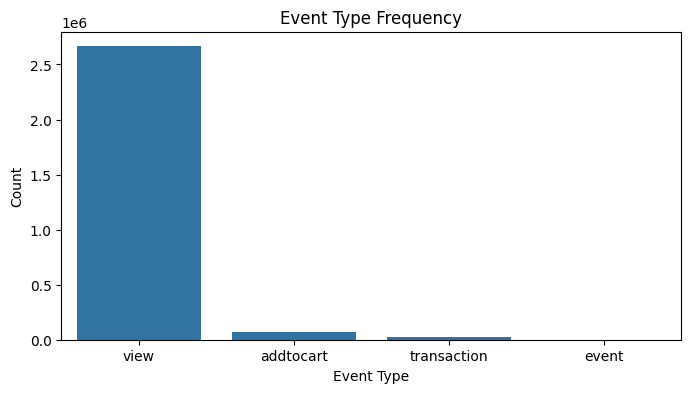

In [21]:
# 4. Event Type Analysis
print("\nEvent Type Counts:")
print(merged_df['event_type'].value_counts())

plt.figure(figsize=(8, 4))
sns.countplot(data=merged_df, x='event_type', 
              order=merged_df['event_type'].value_counts().index)
plt.title("Event Type Frequency")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_24444\334803087.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='viridis')


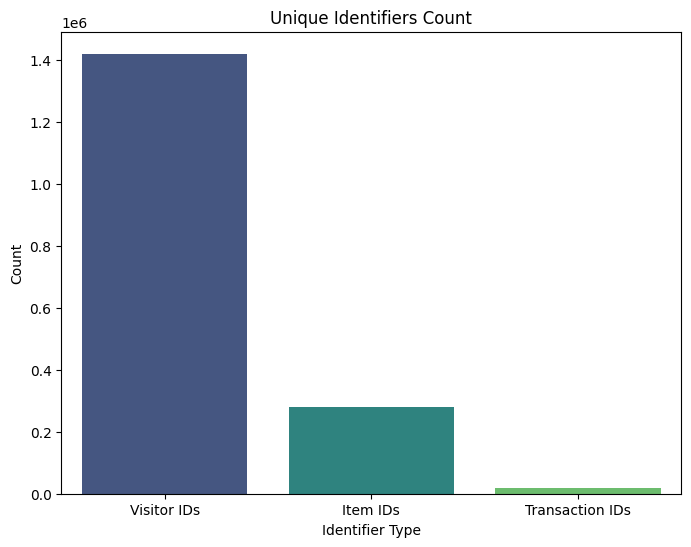

In [24]:
# Get the unique identifier counts
unique_visitors = merged_df['visitor_id'].nunique()
unique_items = merged_df['item_id'].nunique()
unique_transactions = merged_df['transaction_id'].nunique()

# Create data for visualization
labels = ['Visitor IDs', 'Item IDs', 'Transaction IDs']
counts = [unique_visitors, unique_items, unique_transactions]

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=counts, palette='viridis')
plt.title("Unique Identifiers Count")
plt.ylabel("Count")
plt.xlabel("Identifier Type")
plt.show()


Timestamp Summary by Property:
                               min                     max   count
property                                                          
0          2015-05-17 03:16:22.364 2015-09-18 01:27:37.240    5977
1          2015-05-17 12:48:04.981 2015-09-16 15:36:39.372     415
10         2015-05-10 11:37:33.912 2015-09-17 16:26:50.309      60
100        2015-05-16 05:36:06.818 2015-09-18 02:57:17.312      26
1000       2015-05-12 05:09:53.823 2015-09-17 22:26:39.084     782
...                            ...                     ...     ...
998        2015-05-22 19:45:00.570 2015-09-18 00:34:55.564     113
999        2015-05-17 16:06:31.008 2015-09-01 16:05:28.423      34
available  2015-05-10 03:03:17.513 2015-09-18 02:59:41.778  329889
categoryid 2015-05-10 03:02:55.063 2015-09-18 02:59:24.029   71961
property   2015-09-18 02:59:47.788 2015-09-18 02:59:47.788       1

[998 rows x 3 columns]


C:\Users\lenovo\AppData\Local\Temp\ipykernel_24444\3722131913.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_time_summary.index, y=event_time_summary['count'], palette='coolwarm')


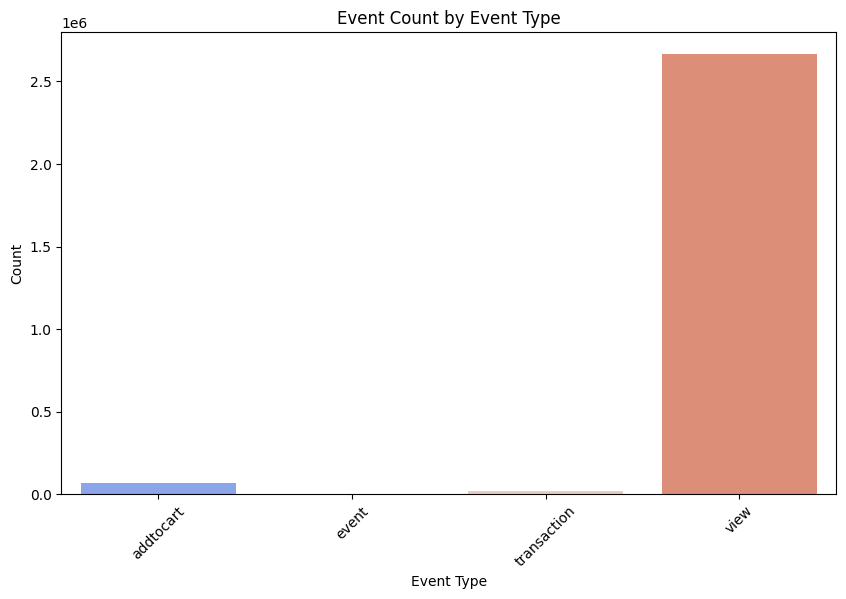

C:\Users\lenovo\AppData\Local\Temp\ipykernel_24444\3722131913.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_properties.index, y=top_properties['count'], palette='viridis')


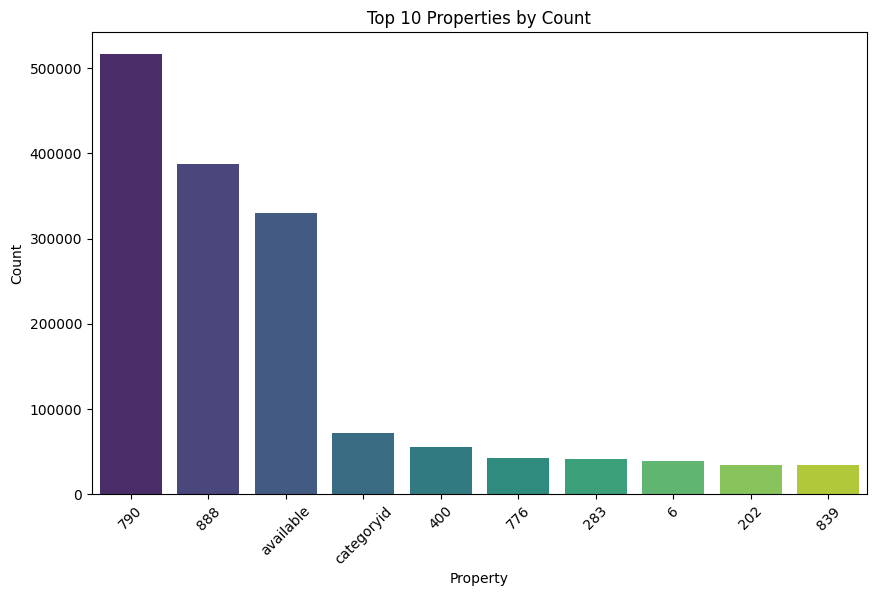

In [26]:
# Group analysis for properties:
property_time_summary = merged_df.groupby('property')['timestamp'].agg(['min', 'max', 'count'])
print("\nTimestamp Summary by Property:")
print(property_time_summary)

# -----------------------
# Visualization for Event Time Summary
# Bar plot: Event count per event type
plt.figure(figsize=(10, 6))
sns.barplot(x=event_time_summary.index, y=event_time_summary['count'], palette='coolwarm')
plt.title("Event Count by Event Type")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# -----------------------
# Visualization for Property Time Summary
# To avoid overcrowding, display top 10 properties by count
top_properties = property_time_summary.sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_properties.index, y=top_properties['count'], palette='viridis')
plt.title("Top 10 Properties by Count")
plt.xlabel("Property")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## DATA CLEANING (Merged_df)

### FILL MISSING VALUES IN COLUMNS

In [ ]:
# Clean 'Transaction ID'- Replace null with a placeholder (e.g., 'no_transaction')
merged_df['transaction_id'] = merged_df['transaction_id'].fillna('no_transaction')

In [28]:
# Clean 'Property'- Replace null with a placeholder (e.g., 'no_property')
merged_df['property'] = merged_df['property'].fillna('no_property')

In [29]:
# Clean 'Value' - Replace null with a placeholder (e.g., 'no_value')
merged_df['value'] = merged_df['value'].fillna('no_value')

Missing Values per Column After Filling:
timestamp         0
visitor_id        0
event_type        0
item_id           0
transaction_id    0
property          0
value             0
dtype: int64


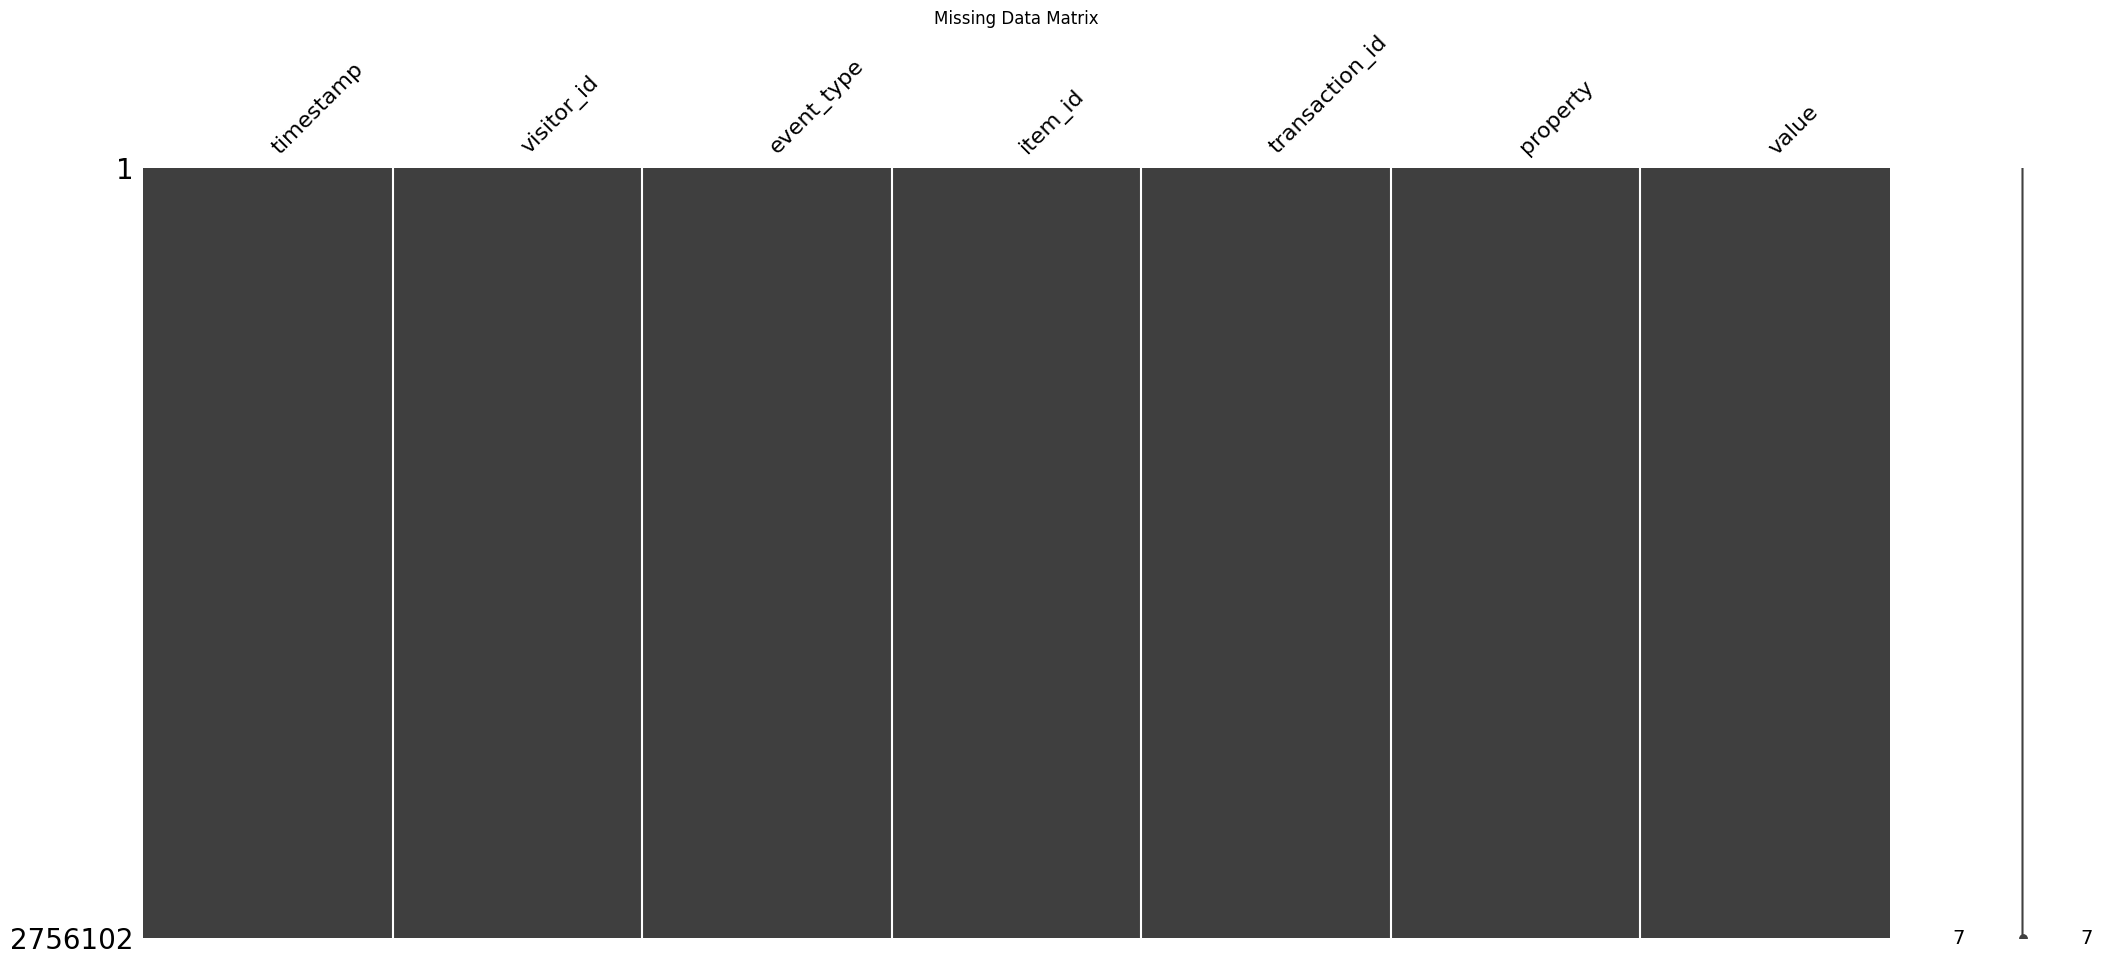

In [30]:
# Confirm changes
print("Missing Values per Column After Filling:")
print(merged_df.isnull().sum())

# Visualize changes
msno.matrix(merged_df)
plt.title("Missing Data Matrix")
plt.show()

### EDA AFTER CLEANING

#### UNIVARIATE ANALYSIS

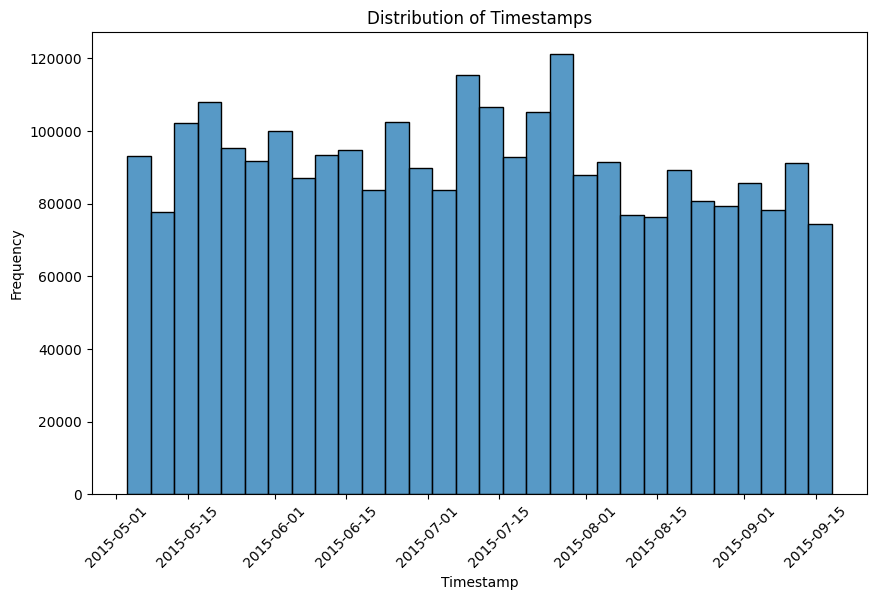

In [32]:
# (A) Timestamp Distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['timestamp'], bins=30, kde=False)
plt.title("Distribution of Timestamps")
plt.xlabel("Timestamp")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


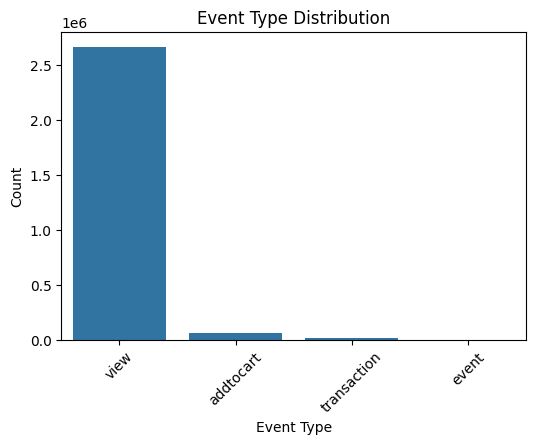

In [33]:

# (B) Event Type Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='event_type', data=merged_df, order=merged_df['event_type'].value_counts().index)
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


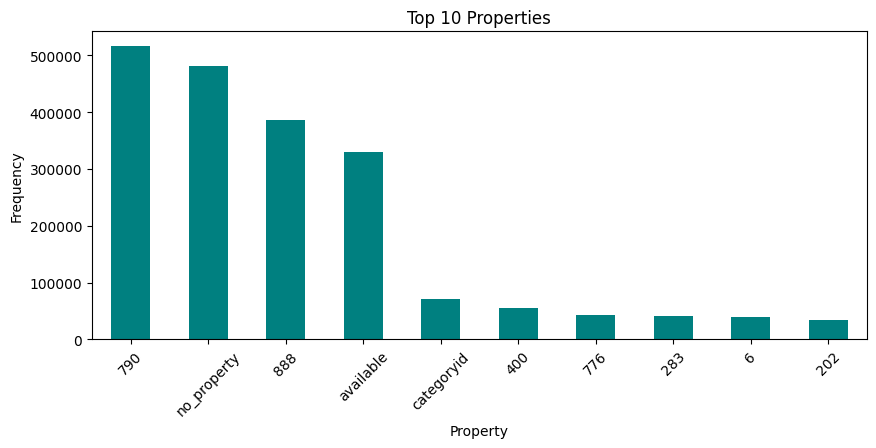

In [34]:

# (C) Property Distribution (Top 10)
plt.figure(figsize=(10, 4))
merged_df['property'].value_counts().head(10).plot(kind='bar', color='teal')
plt.title("Top 10 Properties")
plt.xlabel("Property")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


C:\Users\lenovo\AppData\Local\Temp\ipykernel_24444\1614231090.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


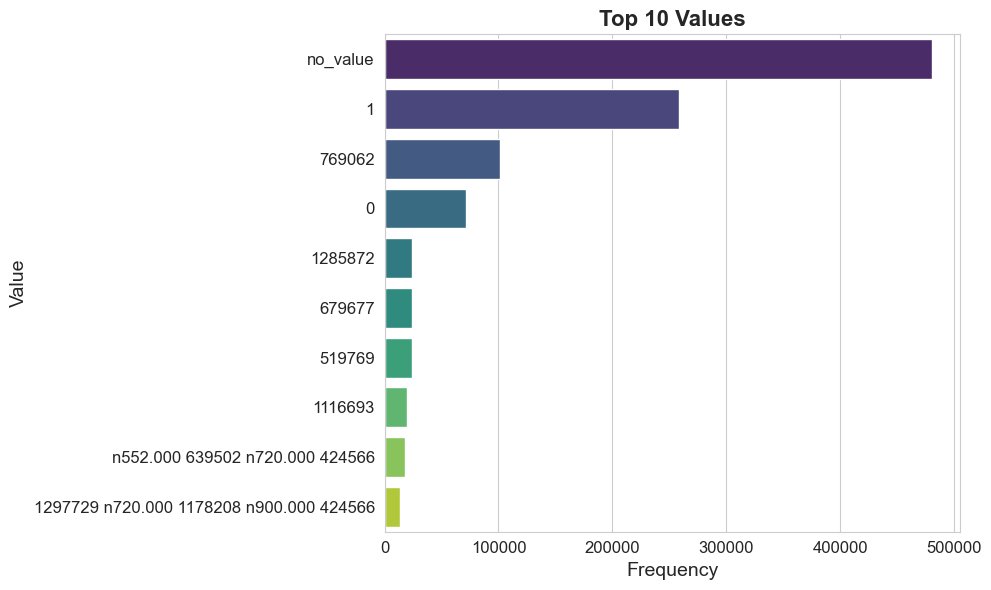

In [ ]:
# (D) Top 10 Values
top_10_values = (
    merged_df['value']             
    .value_counts()                
    .head(10)                      
    .reset_index()                 
)
top_10_values.columns = ['Value', 'Frequency']

# 2. Create the horizontal bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    y='Value',
    x='Frequency',
    data=top_10_values,
    palette='viridis',
    orient='h',  # Horizontal orientation
    order=top_10_values.sort_values('Frequency', ascending=False)['Value']
)

# 3. Customize the title and axis labels
ax.set_title("Top 10 Values", fontsize=16, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)

# 4. Adjust ticks and layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# 5. Display the plot
plt.show()


#### BIVARIATE ANALYSIS

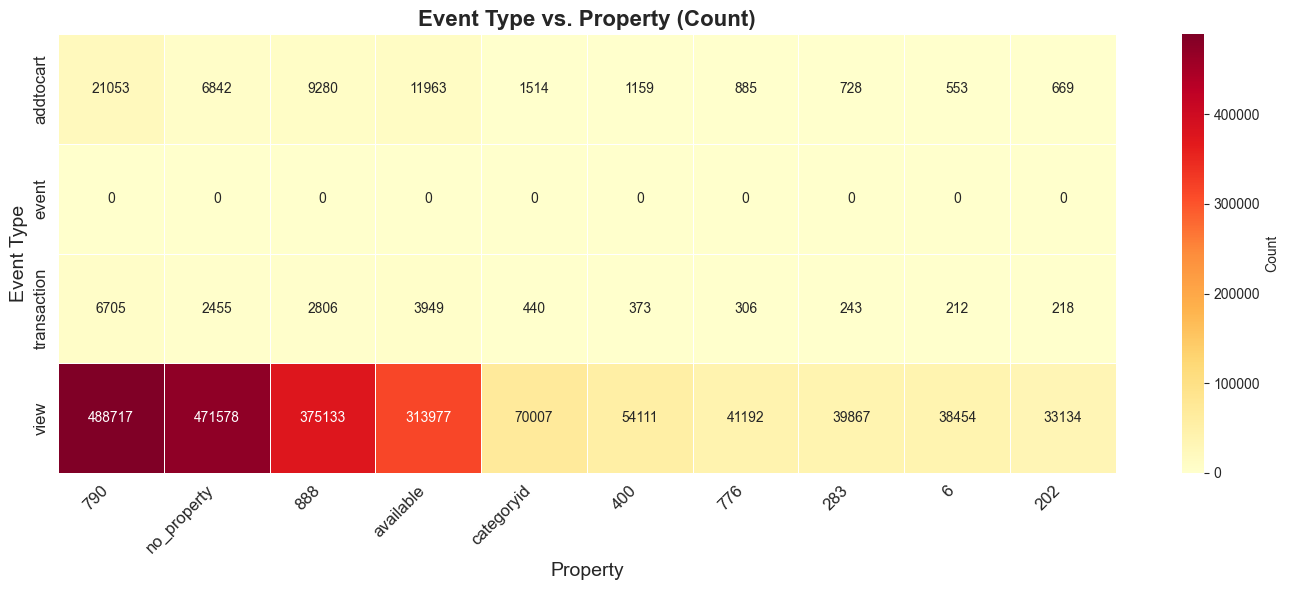

In [40]:
# 1. Create a pivot table of event counts by event_type and property
bivariate_data = merged_df.groupby(['event_type', 'property']).size().reset_index(name='count')
bivariate_pivot = bivariate_data.pivot(index='event_type', columns='property', values='count').fillna(0)

# 2. (Optional) Filter to the top N properties for readability
#    This step is helpful if you have many properties and want a cleaner heatmap.
top_n = 10
property_totals = bivariate_pivot.sum().sort_values(ascending=False)
top_properties = property_totals.head(top_n).index
bivariate_pivot = bivariate_pivot[top_properties]

# 3. Create the heatmap with improved styling
sns.set_style("white")  # background style
plt.figure(figsize=(14, 6))

# Draw the heatmap with:
# - A more vibrant palette
# - Line boundaries between cells
# - Annot=True (optional) to show actual counts in cells (can be omitted if too crowded)
ax = sns.heatmap(
    bivariate_pivot, 
    cmap="YlOrRd", 
    linewidths=0.5, 
    linecolor="white", 
    annot=True,      # or False if it's too busy
    fmt=".0f",       # no decimals for counts
    cbar_kws={"label": "Count"}  # label for the color bar
)

# 4. Customize titles, labels, and ticks
ax.set_title("Event Type vs. Property (Count)", fontsize=16, fontweight="bold")
ax.set_xlabel("Property", fontsize=14)
ax.set_ylabel("Event Type", fontsize=14)

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # avoids clipping of labels
plt.show()


This heatmap results from grouping the events by both event_type and property, then counting how often each combination appears.


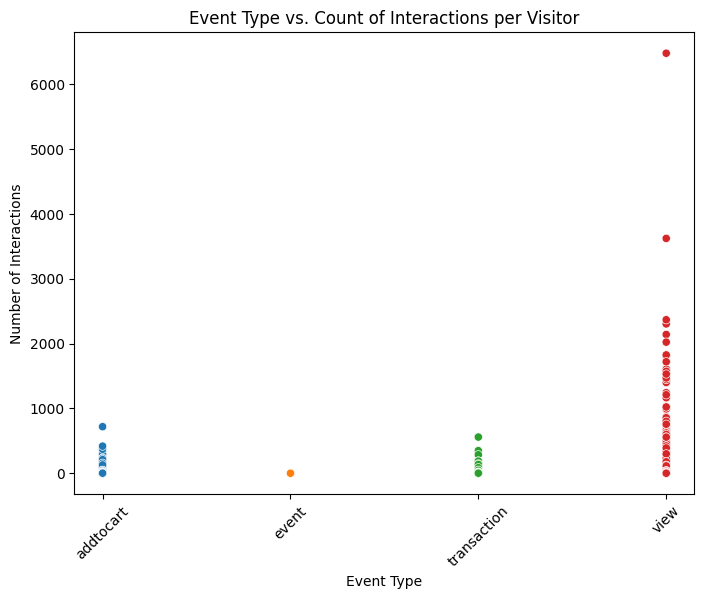

In [37]:

# (B) event_type vs visitor_id (Count of interactions)
visitor_data = merged_df.groupby(['event_type', 'visitor_id']).size().reset_index(name='count')
plt.figure(figsize=(8, 6))
sns.scatterplot(data=visitor_data, x='event_type', y='count', hue='event_type', legend=False)
plt.title("Event Type vs. Count of Interactions per Visitor")
plt.xlabel("Event Type")
plt.ylabel("Number of Interactions")
plt.xticks(rotation=45)
plt.show()

#### MULTIVARIATE ANALYSIS

In [44]:
encoded_df = merged_df.copy()

# Convert *all* object columns to categorical codes
for col in encoded_df.select_dtypes(include='object').columns:
    encoded_df[col] = encoded_df[col].astype('category').cat.codes

# Now compute correlation on the fully numeric DataFrame
corr_matrix = encoded_df.corr()
print(corr_matrix)


                timestamp  visitor_id  event_type   item_id  transaction_id  \
timestamp        1.000000   -0.070055   -0.004444 -0.082033       -0.004509   
visitor_id      -0.070055    1.000000    0.002332  0.153463        0.005858   
event_type      -0.004444    0.002332    1.000000 -0.001606        0.150652   
item_id         -0.082033    0.153463   -0.001606  1.000000        0.006046   
transaction_id  -0.004509    0.005858    0.150652  0.006046        1.000000   
property        -0.046012    0.045285   -0.010565  0.053147       -0.003133   
value           -0.110985    0.062422    0.006106  0.074622        0.005100   

                property     value  
timestamp      -0.046012 -0.110985  
visitor_id      0.045285  0.062422  
event_type     -0.010565  0.006106  
item_id         0.053147  0.074622  
transaction_id -0.003133  0.005100  
property        1.000000  0.069128  
value           0.069128  1.000000  


In [47]:
encoded_df = merged_df.copy()

# Convert only event_type and property to codes, if desired
encoded_df['event_type'] = encoded_df['event_type'].astype('category').cat.codes
encoded_df['property']   = encoded_df['property'].astype('category').cat.codes

# Keep only numeric columns
numeric_df = encoded_df.select_dtypes(include=[np.number])

# Compute correlation
corr_matrix = numeric_df.corr()
print(corr_matrix)

            event_type  property
event_type    1.000000 -0.010565
property     -0.010565  1.000000


In [49]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756102 entries, 0 to 2756101
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       datetime64[ns]
 1   visitor_id      object        
 2   event_type      int8          
 3   item_id         object        
 4   transaction_id  object        
 5   property        int16         
 6   value           object        
dtypes: datetime64[ns](1), int16(1), int8(1), object(4)
memory usage: 113.0+ MB


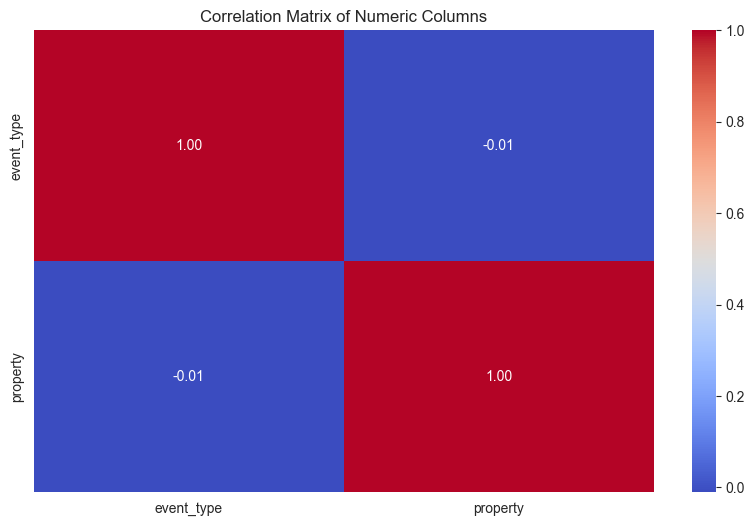

In [48]:

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Columns")
plt.show()

In [ ]:
# change columns 'vistor_id, item_id, value and transaction_id from object to int64

In [54]:
encoded_df['visitor_id'] = pd.to_numeric(encoded_df['visitor_id'], errors='coerce')

In [ ]:
# Option B: Fill with a placeholder (e.g., -1)
encoded_df['visitor_id'] = encoded_df['visitor_id'].fillna(-1).astype('int64')

In [ ]:
# Replace 'no_value' with NaN
encoded_df['value'] = encoded_df['value'].replace('no_value', np.nan)

# Convert the 'value' column to numeric, coercing errors into NaN
encoded_df['value'] = pd.to_numeric(encoded_df['value'], errors='coerce')

# Optionally fill NaN with a default numeric value (e.g., 0) or drop rows with NaN
encoded_df['value'] = encoded_df['value'].fillna(0).astype('int64')

In [59]:
# Replace 'no_transaction' with NaN
encoded_df['transaction_id'] = encoded_df['transaction_id'].replace('no_transaction', np.nan)

# Convert the column to numeric, coercing errors (any non-convertible values become NaN)
encoded_df['transaction_id'] = pd.to_numeric(encoded_df['transaction_id'], errors='coerce')

# Fill NaN with a numeric placeholder, e.g., 0 or -1 (choose what makes sense for your context)
encoded_df['transaction_id'] = encoded_df['transaction_id'].fillna(0).astype('int64')


In [60]:
# change columns 'vistor_id, item_id, value and transaction_id from object to int64
encoded_df['item_id'] = encoded_df['item_id'].astype('int64')

In [61]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2756101 entries, 0 to 2756100
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       datetime64[ns]
 1   visitor_id      int64         
 2   event_type      int8          
 3   item_id         int64         
 4   transaction_id  int64         
 5   property        int16         
 6   value           int64         
dtypes: datetime64[ns](1), int16(1), int64(4), int8(1)
memory usage: 134.0 MB


## HYPOTHESIS TESTING